# 감성 분석 : Sentimetal Analysis

## [1]  데이터 준비

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

- 데이터 로딩 --------------------------------------------------------------

In [48]:
FILE='./data/imdb_reviews.csv'

In [49]:
imdbDF=pd.read_csv(FILE)

- 데이터 확인 ------------------------------------------

In [50]:
imdbDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [51]:
imdbDF.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


- sentimet 컬럼의 데이터 분포 비율

In [52]:
imdbDF.sentiment.value_counts

<bound method IndexOpsMixin.value_counts of 0        1
1        0
2        0
3        1
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    1
Name: sentiment, Length: 50000, dtype: int64>

## [2] 데이터 전처리

### [2-1] 기본 데이터 전처리 : 결측치, 중복값, 노이즈.....

- 결측치 체크 및 처리 ------------------------------------------

In [53]:
imdbDF.isnull().sum()

review       0
sentiment    0
dtype: int64

- 중복값 체크 및 처리 ------------------------------

In [54]:
imdbDF.duplicated().sum()

418

In [55]:
imdbDF.review.duplicated().sum()

418

In [56]:
dpDDF = imdbDF[imdbDF.review.duplicated()]

In [57]:
imdbDF.drop_duplicates(subset=['review'], inplace=True)

### [2-2] 텍스트 데이터 전처리 : 특정문자 외 제외, 구두점, 불용어 처리..

- 텍스트 언어의 문자를 제외한 나머지 삭제 : 영어 a ~ z  ==> 대/소문자 중 하나로 통일

In [58]:
imdbDF.head(3)

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0


In [59]:
# review 컬럼에 대한 소문자 변환
imdbDF.review=imdbDF.review.str.lower()

In [60]:
# review 컬럼에서 a~z과 공백 제외한 모든 것 삭제 
regEng="[^a-zA-Z ]"
imdbDF.review=imdbDF.review.str.replace(regEng, '', regex=True)

In [61]:
imdbDF.review

0        my family and i normally do not watch local mo...
1        believe it or not this was at one time the wor...
2        after some internet surfing i found the homefr...
3        one of the most unheralded great works of anim...
4        it was the sixties and anyone with long hair a...
                               ...                        
49995    the people who came up with this are sick and ...
49996    the script is so so laughable this in turn mak...
49997    so theres this bride you see and she gets crus...
49998    your mind will not be satisfied by this nobudg...
49999    the chasers war on everything is a weekly show...
Name: review, Length: 49582, dtype: object

In [62]:
# review 컬럼에서 구두점 및 특수문자 제거
regPun='[!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n]'
imdbDF.review=imdbDF.review.str.replace(regPun, '', regex=True)

- 불용어 제거 ==> 분석하는 텍스트 데이터에 따라서 추가 및 삭제 가능

In [63]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.append('br')

print(f'불용어 개수 : {len(stop_words)}', stop_words, sep='\n')

불용어 개수 : 180
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [64]:
sw_remove_review=[]
for review in imdbDF.review:
    sw_remove_review.append(' '.join([ word for word in review.split() if word not in stop_words ]))

In [65]:
imdbDF.review=sw_remove_review

In [66]:
#sw_remove_review2=[[ word for word in review.split() if word not in stop_words ] for review in imdbDF.review]

## [3] 학습용 데이터 가공

### [3-1] 텍스트 데이터 ==> 수치화 : 토큰화, 벡터화

- 텍스트 데이터와 맵핑될 숫자 테이블 생성 ==> 단어 사전 (Voca)

In [67]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

-  텍스트 데이터 전용 사전 생성 => VOCA

In [68]:
# 토큰화 시 상수  --------------------------------------------------
OOV='<OOV>'

In [69]:
tk = Tokenizer(oov_token=OOV)

In [70]:
tk.fit_on_texts(imdbDF.review)

In [71]:
len(tk.word_index),tk.word_counts

(175952,
 OrderedDict([('family', 5460),
              ('normally', 546),
              ('watch', 13444),
              ('local', 1723),
              ('movies', 15367),
              ('simple', 1994),
              ('reason', 4375),
              ('poorly', 1311),
              ('made', 15274),
              ('lack', 2079),
              ('depth', 934),
              ('worth', 4591),
              ('timebr', 696),
              ('trailer', 676),
              ('nasaan', 6),
              ('ka', 34),
              ('man', 10228),
              ('caught', 1121),
              ('attention', 1724),
              ('daughter', 2021),
              ('laws', 150),
              ('daughters', 399),
              ('took', 2207),
              ('time', 23077),
              ('afternoon', 317),
              ('movie', 82857),
              ('exceeded', 54),
              ('expectations', 735),
              ('cinematography', 1883),
              ('good', 28370),
              ('story', 21953),
 

In [72]:
seqTEXTS=tk.texts_to_sequences(imdbDF.review)

In [73]:
#  테스트 데이터에 존재하는 단어 수 
VOCA_SIZE=len(tk.word_index)
print(f'사전 단어 수: {VOCA_SIZE}')

사전 단어 수: 175952


- 분석에 사용할 단어 수 => WORD_NUMS

In [74]:
# 단어의 빈도
sorted(tk.word_counts.items(), key=(lambda x:x[1]), reverse=True)

[('movie', 82857),
 ('film', 73930),
 ('one', 50642),
 ('like', 38668),
 ('good', 28370),
 ('even', 24372),
 ('would', 23826),
 ('time', 23077),
 ('really', 22780),
 ('see', 22329),
 ('story', 21953),
 ('much', 18781),
 ('well', 18643),
 ('get', 18058),
 ('great', 17696),
 ('also', 17694),
 ('bad', 17537),
 ('people', 17375),
 ('first', 17005),
 ('dont', 16803),
 ('movies', 15367),
 ('made', 15274),
 ('films', 15199),
 ('make', 15194),
 ('could', 15015),
 ('way', 14884),
 ('characters', 14543),
 ('think', 14107),
 ('watch', 13444),
 ('many', 13284),
 ('seen', 12986),
 ('two', 12908),
 ('character', 12826),
 ('never', 12774),
 ('love', 12477),
 ('acting', 12374),
 ('plot', 12270),
 ('best', 12261),
 ('little', 12216),
 ('know', 12166),
 ('show', 11874),
 ('life', 11588),
 ('ever', 11550),
 ('better', 10954),
 ('still', 10662),
 ('say', 10536),
 ('end', 10465),
 ('scene', 10450),
 ('man', 10228),
 ('scenes', 10107),
 ('something', 9768),
 ('go', 9560),
 ('im', 9389),
 ('back', 9166),
 ('

In [75]:
wordFreq=pd.DataFrame(tk.word_counts.items())
wordFreq[1].value_counts()

1       96705
2       19106
3        9494
4        6089
5        4351
        ...  
3680        1
1514        1
2340        1
1710        1
545         1
Name: 1, Length: 1704, dtype: int64

In [76]:
WORD_NUMS = wordFreq[wordFreq[1]>=10].shape[0]

print(f'분석에 사용할 단어 수 : {WORD_NUMS}')

분석에 사용할 단어 수 : 30075


In [77]:
wordFreq[1].min(), wordFreq[1].max()

(1, 82857)

(array([164933.,   4319.,   1746.,   1017.,    689.,    427.,    335.,
           279.,    218.,    190.]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.]),
 <BarContainer object of 10 artists>)

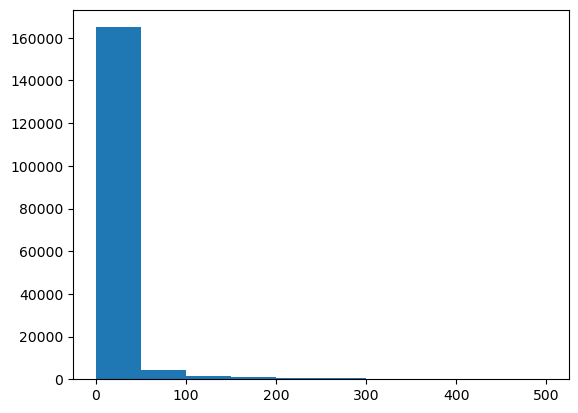

In [78]:
plt.hist(wordFreq[1], bins=10, range=(0, 500))

- 텍스트 길이 결정 ==>  review 길이 가변이므로

In [79]:
#  텍스트 ==> 숫자로 변환
seqText=tk.texts_to_sequences(imdbDF.review)

In [80]:
seqTextLen=pd.Series([ len(text) for text in seqText ])

In [81]:
seqTextLen.median(), seqTextLen.min(), seqTextLen.max(), seqTextLen.mean()

(89.0, 3, 1430, 119.35964664596023)

In [82]:
len(seqTextLen[seqTextLen>89]), len(seqTextLen[seqTextLen>110]), len(seqTextLen[seqTextLen>130])

(24492, 18377, 14574)

<AxesSubplot:ylabel='Frequency'>

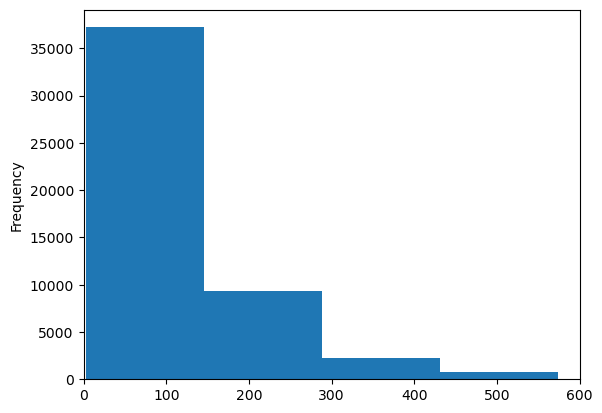

In [83]:
# 문장별 단어 수 길이 분포 ----------------------------
seqTextLen.plot(kind='hist', xlim=[0, 600])

In [84]:
TEXT_LENGTH=int(seqTextLen.median())

-  모든 텍스트 길이 일치 ==> 패딩

In [85]:
textData=pad_sequences(seqText, maxlen=TEXT_LENGTH)

type(textData), textData.shape,  imdbDF.sentiment.shape

(numpy.ndarray, (49582, 89), (49582,))

In [86]:
textLabel=imdbDF.sentiment

### [3-2] 학습/검증/테스트 데이터 준비

In [87]:
from sklearn.model_selection import train_test_split

In [88]:
X_train, X_test, y_train, y_test = train_test_split(textData,
                                                    textLabel, 
                                                    test_size=0.2,
                                                    stratify=textLabel)

In [89]:
X_train.shape, y_train.shape,  X_test.shape, y_test.shape

((39665, 89), (39665,), (9917, 89), (9917,))

In [90]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                    y_train, 
                                                    test_size=0.2,
                                                    stratify=y_train)

In [91]:
X_train.shape,y_train.shape, X_val.shape, y_val.shape

((31732, 89), (31732,), (7933, 89), (7933,))

- RNN 입력형태로 변환 ==> (배치사이즈, 타임스템프,피쳐수) => (배치사이즈, TEXT_LENGTH,WORD_NUMS)

In [92]:
from tensorflow.keras.utils import to_categorical

In [97]:
to_categorical(X_train[:100]).shape

(100, 89, 175377)

## [4]  모델 설계 및 생성

### [4-1] layer에 맞는 shape으로 변환 ==> 

### [4-2] 모델 설계 & 생성
* sequential api 방식
* simpleRNN 층 <= 입력층
* Dense 층 <= 출력층

### [4-3] 모델학습

## [5] 테스트 진행

## [6] 예측 및 저장 여부 결정